# Multi Agent Demo Recursive and Langraph Combined

See link [LANGGRAPH_COMPARSION](https://github.com/hankbesser/recursive-companion-complete/blob/main/docs/LANGGRAPH_COMPARISON.md) for more.

In [1]:
#from dotenv import load_dotenv
#load_dotenv()

In [2]:
import os
api_key_status = "Loaded" if os.getenv("OPENAI_API_KEY") else "NOT FOUND - Check your .env file and environment."
print(f"OpenAI API Key status: {api_key_status}")

OpenAI API Key status: Loaded


In [3]:
# imports
from IPython.display import Image, display, Markdown
from langchain_core.runnables import RunnableLambda
from langgraph.graph import StateGraph
from typing import TypedDict
from recursive_companion.base import MarketingCompanion, BugTriageCompanion, StrategyCompanion

In [4]:
# different models for differents domains
llm_fast  = "gpt-4o-mini"
llm_deep  = "gpt-4.1-mini" 

In [5]:
# create the agents
# tip readthe doctring by hovering over the class
mkt   = MarketingCompanion(llm=llm_fast, temperature=0.8, max_loops=3, similarity_threshold=0.96)
eng   = BugTriageCompanion(llm=llm_deep, temperature=0.3)
plan = StrategyCompanion(llm=llm_fast)

In [6]:
# Each node is now a first-class Runnable; you get built-in tracing, concurrency, retries, etc., without rewriting your engine.
mkt_node  = RunnableLambda(mkt)          # __call__ alias does the trick
eng_node  = RunnableLambda(eng)

In [7]:
# merge-lambda joins text views into one string
# note: LangGraph passes the entire upstream-state dict to a node.
# with out this function, two upstream nodes are piped straight into strategy, 
# so plan_node will receive a Python dict like {"engineering": "...", "marketing": "..."}.
# That's fine if your StrategyCompanion prompt expects that JSON blob, 
# but most of the time you'll want to concatenate the two strings first.

merge_node = RunnableLambda(
    lambda d: f"### Marketing\n{d['marketing']}\n\n### Engineering\n{d['engineering']}"
)
plan_node  = RunnableLambda(plan)

# Define the state schema for LangGraph
class GraphState(TypedDict):
    input: str
    marketing: str
    engineering: str
    merged: str
    final_plan: str

# Inline LangGraph example (fan-in)
# No extra prompts, no schema gymnastics: simply passing text between the callables the classes already expose.
graph = StateGraph(GraphState)
graph.add_node("marketing_agent",    lambda state: {"marketing": mkt_node.invoke(state["input"])})
graph.add_node("engineering_agent",  lambda state: {"engineering": eng_node.invoke(state["input"])})
graph.add_node("merge_agent",        lambda state: {"merged": merge_node.invoke(state)})
graph.add_node("strategy_agent",     lambda state: {"final_plan": plan_node.invoke(state["merged"])})

graph.add_edge("marketing_agent", "merge_agent")
graph.add_edge("engineering_agent", "merge_agent")
graph.add_edge("merge_agent", "strategy_agent")

graph.add_edge("__start__", "marketing_agent")
graph.add_edge("__start__", "engineering_agent")
graph.set_finish_point("strategy_agent")
workflow = graph.compile()

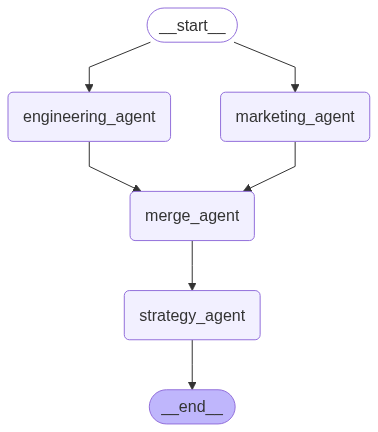

In [8]:
#display the graph
display(Image(workflow.get_graph().draw_mermaid_png()))

In [9]:
result = workflow.invoke(
    {"input": "App ratings fell to 3.2★ and uploads crash on iOS 17.2. Diagnose & propose next steps."}
)

In [11]:
final = result.get("final_plan", "")

In [17]:
print("\n=== FINAL PLAN ===\n")
display(Markdown(final))


=== FINAL PLAN ===



### Overview of Marketing and Engineering Insights on Declining App Ratings

#### Marketing Insights
1. **Decline in App Ratings**: The app's average rating has decreased significantly from 4.5 stars to 3.2 stars. This decline is mainly due to usability challenges, the removal of the popular "quick upload" feature, and increased bug reports, including crashes during uploads.

2. **Compatibility Issues with iOS 17.2**: Recent upload crashes reported exclusively on devices running iOS 17.2 indicate a pressing need for technical fixes to improve user satisfaction and restore confidence in the app.

3. **User Feedback Analysis**: We will conduct a structured review of user feedback, categorizing complaints into specific themes. This approach will help pinpoint key issues affecting user satisfaction and experience, allowing us to prioritize our responses effectively.

4. **Engagement Metrics**: Analyzing user engagement metrics—such as daily active users and session duration—before and after the iOS 17.2 update will clarify how these metrics relate to technical issues and user ratings. For example, declines in user engagement may indicate negative user experiences, which could correlate with the drop in app ratings.

5. **Brand Touchpoints**: Understanding user interactions across various channels, including social media and customer support, will provide valuable insights into user perceptions during this decline. This knowledge will inform our communication strategies aimed at addressing concerns and enhancing overall satisfaction.

6. **Demographic Insights**: Identifying the user demographics most affected by these issues is crucial. We plan to gather this data through user surveys and analytics tools, aiming to complete this within the next month to tailor improvements that meet the specific needs of these groups.

#### Engineering Insights
1. **Current Issues**: The significant decrease in app ratings aligns with reports of upload crashes on iOS 17.2, likely serving as the primary cause of user dissatisfaction.

2. **Temporal Correlations**: We need to verify when the crashes began in relation to the iOS update and analyze their frequency, confirming whether they occurred immediately after the update or developed over time.

3. **Key Unknowns**: Identifying the specific conditions triggering the crashes is vital. This includes understanding affected device models, app versions, and any recent updates that could be relevant to troubleshooting efforts.

4. **Initial Hypotheses**: The upload crash may stem from incompatibility between the app's upload functionality and the changes introduced in iOS 17.2. Recent app updates could also exacerbate these issues, necessitating a thorough review.

5. **Available Data and Gaps**: We currently lack detailed crash logs, user demographics, and telemetry data, all of which are essential for an accurate diagnosis and understanding of user experiences.

6. **Recommended Next Steps**:
   - **Reproduce the Crash**: Attempt to replicate the upload crash in a controlled environment using affected app versions on devices running iOS 17.2. Document conditions and reproducibility.
   - **Collect Diagnostics**: Gather crash logs, stack traces, and error reports from users experiencing crashes to inform our technical fixes.
   - **Scope Identification**: Determine affected device models, iOS versions, app versions, and geographic locations through telemetry and support data.
   - **Analyze Recent Changes**: Review recent app updates, feature flag modifications, and third-party SDK updates for potential regressions or incompatibilities.
   - **Examine Backend Systems**: Analyze server-side logs and system health related to uploads during the issue timeframe to identify any contributing factors.
   - **Telemetry Analysis**: Evaluate upload success/failure rates, user session data, and network error rates to reveal patterns or triggers.
   - **Review iOS 17.2 Resources**: Consult iOS 17.2 release notes and known issues from various sources to gather relevant information.
   - **Cross-Version Testing**: Test if upload crashes occur on other iOS versions or platforms to isolate the problem's scope.
   - **User Feedback Analysis**: Analyze app store reviews, social media, and support channels to understand user sentiment and impact.

7. **Interim Mitigation and Communication**: We will communicate proactively with users regarding ongoing issues and potential temporary limitations on upload functionality. Strategies may include in-app notifications, social media updates, and support channels to keep users informed about the status and timelines for fixes.

### Relationships and Insights
- **App Ratings and iOS Version**: There is a notable correlation between the iOS 17.2 update and the drop in app ratings. Understanding this link emphasizes the need for urgent technical intervention while acknowledging that further investigation is required to establish causation.

- **Engagement Metrics and Ratings**: Marketing identifies engagement metrics as critical to understanding user satisfaction, aligning with engineering's focus on crash reproducibility and telemetry data analysis to identify user experience impacts.

- **User Feedback and Demographics**: Both perspectives recognize user feedback's importance, with engineering emphasizing the need for demographic insights to identify affected user groups.

### Data Gaps
1. **User Feedback**: While marketing aims to analyze user reviews for specific issues, engineering requires detailed crash logs and error reports. Collaboration is necessary to gather comprehensive feedback.

2. **Technical Reports**: Both perspectives call for deeper investigation into the nature of crashes. Engineering emphasizes the lack of telemetry data and crash logs, which need to be addressed.

3. **User Segmentation**: Marketing highlights the need for demographic data, which engineering recognizes as vital for understanding affected user groups.

4. **Competitor Analysis**: Marketing suggests assessing competitor apps, which can provide context on the app's performance issues and trends.

5. **Historical Data Comparison**: Engineering needs historical performance data to identify trends, which marketing can assist in providing.

### Next Steps
1. **Immediate Technical Fixes**: Engineering should prioritize fixing the upload crashes on iOS 17.2. Marketing will prepare user communications to manage expectations regarding resolution timelines.

2. **Task Force Formation**: Establish a cross-functional task force comprising both marketing and engineering teams to collaboratively address user feedback and technical issues.

3. **User Feedback Analysis**: Conduct a thorough review of user feedback over the next week, focusing on categorizing and analyzing critical issues and themes needing attention.

4. **Competitor Benchmarking**: Marketing should initiate competitive analysis within two weeks to evaluate how similar apps are performing under the new iOS version, focusing on features, user ratings, and user feedback.

5. **Demographic Study**: Both teams should collaborate on collecting demographic data through surveys and analytics tools, aiming for completion within a month to inform targeted improvements.

By addressing these areas collaboratively, we will develop a clearer understanding of the challenges at hand, leading to informed decision-making and enhanced user experience.

In [13]:
# === After LangGraph workflow completes ===
print("\n🔍 DEEP INTROSPECTION - What LangGraph CAN'T normally show you:\n")
# Show iteration counts
print(f"Marketing iterations: {len(mkt.run_log)}")
print(f"Engineering iterations: {len(eng.run_log)}")
print(f"Strategy iterations: {len(plan.run_log)}")
# Show why each converged
print("\n📊 CONVERGENCE ANALYSIS:")
for name, agent in [("Marketing", mkt), ("Engineering", eng), ("Strategy", plan)]:
    if len(agent.run_log) < agent.max_loops:
        print(f"{name}: Converged early (quality threshold reached)")
    else:
        print(f"{name}: Used all {agent.max_loops} iterations")



🔍 DEEP INTROSPECTION - What LangGraph CAN'T normally show you:

Marketing iterations: 2
Engineering iterations: 3
Strategy iterations: 2

📊 CONVERGENCE ANALYSIS:
Marketing: Converged early (quality threshold reached)
Engineering: Used all 3 iterations
Strategy: Converged early (quality threshold reached)


In [14]:
# Show full thinking process for marketing agent
print("\n🧠 MARKETING THINKING PROCESS:")
display(Markdown(mkt.transcript_as_markdown()))



🧠 MARKETING THINKING PROCESS:



--------------------------------------------------------------------------------

## Initial Draft

--------------------------------------------------------------------------------

The marketing challenge at hand involves a significant decline in app ratings, which have fallen to 3.2 stars, alongside a noticeable crash of uploads on the recent iOS version 17.2. This situation raises several key market signals and issues that need careful consideration.

### Key Market Signals and Issues

1. **App Ratings Decline**:
   - The drop to 3.2 stars indicates a negative shift in user satisfaction. This could be a result of various factors, including usability issues, feature changes, or bugs introduced in the latest update.

2. **Compatibility Issues with iOS 17.2**:
   - The report of upload crashes specifically on iOS 17.2 suggests a compatibility issue between the app and the most recent version of Apple's operating system. This technical problem could be influencing user ratings and overall engagement negatively.

3. **User Feedback**:
   - If available, analysis of user reviews on the app store can provide insight into specific complaints or issues being reported by users. Identifying common themes in feedback could highlight the main areas of concern.

4. **Engagement Metrics**:
   - Changes in user engagement metrics prior to and after the iOS 17.2 update should be assessed. This includes tracking active users, session duration, and frequency of use to gauge overall app performance among the user base.

5. **Brand Touchpoints**:
   - Examination of user interactions with the brand through different touchpoints—such as social media channels, customer support, and in-app communications—could reveal how users perceive the app and the brand overall during this downturn.

6. **Demographic Insights**:
   - Understanding which user demographics are most affected by the decline in ratings and upload crashes is critical. Analyzing data across different age groups, regions, or device types can help pinpoint the segments experiencing the most dissatisfaction.

### Apparent Relationships

- **App Ratings vs. iOS Version**: There is a direct correlation between the timing of the iOS 17.2 update and the drop in app ratings. Users experiencing crashes are likely to leave negative reviews, impacting the overall rating.
  
- **Engagement Metrics and Ratings**: A decline in engagement metrics may be closely related to the decrease in app ratings. If users face issues with uploads, their willingness to leave positive feedback diminishes.

- **User Feedback and Demographic Insights**: Specific demographics may be more vocal in their dissatisfaction, suggesting a skew in feedback that could be tied to particular user experiences on iOS 17.2.

### Points Where More Data is Needed

1. **Detailed User Feedback**: A deeper analysis of user reviews, including sentiment analysis, could help in identifying precise issues causing dissatisfaction.

2. **Technical Reports**: Understanding the nature of the crashes on iOS 17.2 through technical logs and user reports can assist in pinpointing the exact problems.

3. **User Segmentation**: Additional segmentation data based on user behavior and demographics can provide clarity on which groups are most affected and how their experiences differ.

4. **Competitor Analysis**: Observing how competitors' apps are performing on iOS 17.2 can offer insights into whether this is a broader issue or specific to the app in question.

5. **Historical Data**: Comparing current performance metrics against historical data from previous iOS versions can highlight trends or patterns that emerged with the introduction of iOS 17.2.

By mapping these signals, relationships, and data gaps, a clearer understanding of the current marketing challenge can be developed, paving the way for informed decision-making regarding potential strategies or actions moving forward.
## Iteration 1

--------------------------------------------------------------------------------

### Critique 1

--------------------------------------------------------------------------------

1. **Clarity of Problem Definition**: 
   - The initial description of the problem could be clearer. The phrase "a significant decline in app ratings" may benefit from more specific context around the significance of this drop. For instance, it would be helpful to mention the previous rating before the decline and how this impacts user perception or app visibility.
   - **Suggestion**: Reword to include a comparison to previous ratings (e.g., “app ratings have fallen from an average of 4.5 stars to 3.2 stars, indicating a significant shift in user perception and satisfaction.”).

2. **Over-generalization of Issues**: 
   - The section on “App Ratings Decline” implies various factors without delving into specific examples or real-time data, which could be misleading. It's essential to address that changes in ratings can vary widely depending on different app features or bugs.
   - **Suggestion**: Provide examples of known issues that typically lead to rating declines, such as specific features that were altered or removed in the latest update.

3. **Lack of Specificity in User Feedback Analysis**: 
   - The recommendation to analyze user feedback lacks direction regarding which specific aspects to review (e.g., functionality, features, bugs). The critique suggests looking at user reviews, but it misses the point of how to effectively categorize and prioritize that feedback.
   - **Suggestion**: Specify that feedback should be categorized into themes such as bugs, feature requests, and usability issues for a more structured analysis.

4. **Demographic Insights Section**: 
   - The critique mentions the importance of understanding which user demographics are affected, but it does not explain how to gather this demographic data or why it might be significant to the analysis.
   - **Suggestion**: Include methods for acquiring demographic insights, such as app analytics tools, surveys, or user data, and clarify how understanding these segments could tailor the app’s improvements.

5. **App Ratings vs. iOS Version Relationship**: 
   - The relationship between app ratings and the iOS version could be expanded. It currently oversimplifies the connection without considering how an app's specific features interact with system updates.
   - **Suggestion**: Elaborate on potential specific interactions or changes in functionality that could lead to user dissatisfaction due to iOS updates, such as new privacy policies or user interface changes.

6. **Engagement Metrics and Ratings**: 
   - The correlation between engagement metrics and ratings is mentioned but could be more thoroughly investigated. There is no mention of how to measure or analyze these metrics.
   - **Suggestion**: Suggest specific engagement metrics to analyze such as daily active users, churn rate, and user session length, and how these could correlate to the ratings.

7. **Technical Reports Section**: 
   - The draft suggests needing technical reports but does not explain what specific technical aspects should be investigated or what tools could be used to gather this information.
   - **Suggestion**: Recommend specific logging tools or metrics to analyze crash reports, such as crash log analysis software or patterns in user feedback that indicate technical difficulties.

8. **Competitor Analysis**: 
   - The mention of competitor analysis is vague; it would be beneficial to specify what aspects of competitor performance should be examined in relation to iOS 17.2.
   - **Suggestion**: Highlight specific metrics to compare, like ratings, review sentiment, or feature offerings, to provide a clearer picture of the competitive landscape.

9. **Overall Structure**: 
   - The structure of the response could benefit from better organization. The sections feel somewhat disjointed and could be more logically sequenced to enhance flow.
   - **Suggestion**: Consider organizing the sections under broader headings, such as “Diagnosis,” “User Insights,” “Technical Assessment,” and “Strategic Recommendations,” to create a clearer narrative.

10. **Missing Next Steps**: 
    - While the draft outlines issues and potential areas for further investigation, it lacks concrete next steps or immediate actions to take based on the findings.
    - **Suggestion**: Conclude with a clear list of actionable next steps based on the analysis, such as forming a task force to address user feedback, scheduling immediate app updates to fix crashes, or conducting a competitive analysis in the next week.

**Overall Assessment**: 
The draft provides a good foundational understanding of the issues surrounding app ratings and crashes on iOS 17.2, but it lacks depth and specificity in critical areas. By enhancing clarity and providing actionable insights, the response can be significantly improved to guide effective decision-making. The structure could also be refined for better coherence. Targeted revisions based on the suggestions provided will help create a more comprehensive and actionable analysis.

### Revision 1

--------------------------------------------------------------------------------

The current issue involves a notable decline in app ratings, which have dropped from an average of 4.5 stars to 3.2 stars, indicating a significant shift in user perception and satisfaction. This decline coincides with upload crashes specifically reported on iOS version 17.2, suggesting that recent updates may be impacting user experience adversely.

### Diagnosis

1. **Decline in App Ratings**:
   - The fall to 3.2 stars signifies a critical decrease in user satisfaction. Factors contributing to this drop may include usability issues, the removal of popular features, or bugs introduced in the most recent update. Understanding these specifics is essential for addressing user concerns effectively.

2. **Compatibility Issues with iOS 17.2**:
   - The upload crashes reported exclusively on iOS 17.2 point to a compatibility problem between the app and the latest version of Apple’s operating system. Such technical issues can diminish user engagement and lead to negative ratings, as frustrated users are likely to express their dissatisfaction in reviews.

3. **User Feedback Analysis**:
   - A detailed analysis of user reviews is crucial. Feedback should be categorized into themes such as bugs, feature requests, and usability concerns. Identifying common complaints will help prioritize areas for improvement and target specific issues affecting user satisfaction.

4. **Engagement Metrics**:
   - It is vital to analyze user engagement metrics before and after the iOS 17.2 update. Key metrics to consider include daily active users, session duration, churn rate, and frequency of use. These metrics can provide insights into how technical issues or feature changes correlate with user ratings.

5. **Brand Touchpoints**:
   - Investigating user interactions across various brand touchpoints—such as social media, customer support channels, and in-app messaging—can provide a comprehensive view of user perceptions during this decline. Understanding how users relate to the brand can inform potential communication strategies.

6. **Demographic Insights**:
   - Identifying which user demographics are most affected is essential. Gathering demographic data through app analytics tools, user surveys, or existing user data can reveal specific segments experiencing dissatisfaction. Tailoring improvements to these segments may enhance overall user experience.

### Relationships and Insights

- **App Ratings vs. iOS Version**: The timing of the iOS 17.2 update appears to directly correlate with the drop in app ratings. Users encountering crashes are more likely to leave negative reviews, impacting overall ratings significantly.

- **Engagement Metrics and Ratings**: A decline in engagement metrics often correlates with lower app ratings. If users are unable to upload content due to crashes, their likelihood of providing positive feedback diminishes.

- **User Feedback and Demographics**: Certain demographics may be particularly vocal about their dissatisfaction, indicating that their experiences with the app could be influencing the overall feedback landscape.

### Data Gaps

1. **Detailed User Feedback**: Conducting sentiment analysis on user reviews will help identify specific issues causing dissatisfaction. Prioritizing feedback based on themes will enable a more structured approach to addressing concerns.

2. **Technical Reports**: Investigating the nature of the crashes on iOS 17.2 through crash log analysis tools and user reports will help pinpoint specific technical failures that need addressing.

3. **User Segmentation**: Collecting and analyzing demographic data will clarify which user groups are most impacted and how their experiences differ. This insight can guide targeted improvements.

4. **Competitor Analysis**: Assessing competitor apps on iOS 17.2 will provide context for understanding whether the issues faced are unique to this app or part of a broader trend. Metrics to compare include ratings, review sentiment, and feature offerings.

5. **Historical Data Comparison**: Analyzing current performance metrics against historical data from previous iOS versions can highlight patterns that emerged with the introduction of iOS 17.2, offering insights into user expectations.

### Next Steps

1. **Form a Task Force**: Assemble a dedicated team to address user feedback and prioritize improvements based on categorized themes.

2. **Immediate Technical Fixes**: Schedule an urgent update to rectify the upload crashes on iOS 17.2 to restore functionality and user confidence in the app.

3. **User Feedback Analysis**: Conduct a comprehensive analysis of user reviews, focusing on identifying critical issues and themes over the next week.

4. **Competitor Benchmarking**: Initiate a competitor analysis to understand how similar apps are performing under the new iOS version, aiming to complete this assessment within two weeks.

5. **Demographic Study**: Gather user demographic data through surveys and analytics tools to inform targeted enhancements that address specific user needs.

By addressing these areas and implementing the outlined next steps, a clearer understanding of the current challenges can be developed, leading to informed decision-making and improved user experience in the future.
## Iteration 2

--------------------------------------------------------------------------------

### Critique 2

--------------------------------------------------------------------------------

1. **Clarity and Specificity of Diagnosis**:
   - The diagnosis points are somewhat general and lack specificity. For instance, stating that "factors contributing to this drop may include usability issues, the removal of popular features, or bugs" does not provide concrete examples or data to support these claims.
   - **Suggestion**: Integrate specific user feedback points or examples from reviews that highlight usability issues or bugs to enhance clarity and specificity. For instance, mention particular features users have complained about and provide quantitative data if available.

2. **Technical Issues with iOS 17.2**:
   - The document suggests a direct correlation between app crashes and ratings decline but could benefit from a more precise articulation of the nature of the crashes (e.g., are they related to specific actions within the app?).
   - **Suggestion**: Include details about the types of crashes reported (e.g., app freezes, error messages) and whether they have been verified through crash logs or user reports. This will strengthen the argument regarding the technical issues.

3. **User Feedback Analysis**:
   - While user feedback analysis is mentioned, the draft does not specify how this analysis will be conducted beyond categorization. The process may be unclear to those unfamiliar with it.
   - **Suggestion**: Clarify the approach to user feedback analysis, such as using specific tools or methodologies (like sentiment analysis software) and what key metrics will be examined. This will provide a clearer roadmap for stakeholders.

4. **Engagement Metrics**:
   - The section mentions various engagement metrics but does not connect these metrics to the proposed next steps adequately. It could be misinterpreted without further explanation.
   - **Suggestion**: Tie engagement metrics more explicitly into the next steps by suggesting specific metrics to monitor post-implementation of fixes and how these metrics will inform future updates.

5. **Relationships and Insights**:
   - The connections drawn between app ratings, iOS version, and engagement metrics could be better articulated to highlight the causative relationships rather than simply stating they are correlated.
   - **Suggestion**: Use a more narrative approach to describe how user frustrations due to crashes lead to lower engagement, which then directly influences app ratings. For example, explain how lower engagement leads to fewer positive reviews and potentially more negative ones.

6. **Data Gaps**:
   - The list of data gaps includes relevant points but lacks a clear linkage to the overall problem. It feels somewhat disconnected from the main narrative.
   - **Suggestion**: Reorganize the data gaps section to directly address how filling each gap will lead to actionable insights or improvements in the app. For instance, explain why competitor analysis is essential in understanding the app’s positioning in the marketplace.

7. **Next Steps**:
   - The next steps are robust but could benefit from a more prioritized or time-sensitive approach. Currently, they appear somewhat sequential without clear urgency.
   - **Suggestion**: Specify which steps should be prioritized based on impact and urgency, such as addressing technical fixes before comprehensive user feedback analysis. Indicate clear timelines for each action where possible to convey urgency.

8. **Overall Structure and Flow**:
   - The overall structure is logical; however, the transitions between sections could be smoother. Some points seem abrupt and lack a cohesive narrative throughout the draft.
   - **Suggestion**: Use transitional phrases or sentences at the end of each section to guide readers to the next topic. For example, after discussing user feedback, you might end with a sentence that emphasizes the connection between user sentiment and the need for technical fixes.

9. **Missing Information**:
   - The draft does not address the potential impact of external factors beyond iOS 17.2 on app ratings, such as market competition or changes in user expectations.
   - **Suggestion**: Consider including a brief analysis of any external trends or factors that might be influencing app ratings, such as competitor actions, user behavior changes, or industry shifts. This will provide a more comprehensive view of the context surrounding the app’s performance.

### Overall Assessment:
The draft effectively outlines the issues surrounding the app’s ratings and functionality but requires additional detail, specificity, and clarity to enhance its effectiveness. By incorporating more concrete examples, refining connections between points, and ensuring that each section flows logically into the next, the analysis will become clearer and more actionable. Strengthening the relationship between data gaps and proposed solutions will also aid in making the recommendations more compelling. 

Incorporating these critiques and suggestions will lead to a more robust and effective response to the initial request, ultimately paving the way for a clear plan of action to address the app's challenges.
### Final Answer

--------------------------------------------------------------------------------

The current issue involves a notable decline in app ratings, which have dropped from an average of 4.5 stars to 3.2 stars, indicating a significant shift in user perception and satisfaction. This decline coincides with upload crashes reported specifically on iOS version 17.2, suggesting that recent updates may be adversely impacting user experience.

### Diagnosis

1. **Decline in App Ratings**:
   - The drop to 3.2 stars signifies a critical decrease in user satisfaction. Specific factors contributing to this drop include reported usability issues, such as difficulty navigating the app after recent updates and complaints about the removal of a popular feature, the “quick upload” option, which many users found convenient. Additionally, numerous users have pointed out bugs, like the app unexpectedly closing during uploads. Analyzing these specific points will be essential for effectively addressing user concerns.

2. **Compatibility Issues with iOS 17.2**:
   - The upload crashes reported exclusively on iOS 17.2 indicate a compatibility problem between the app and the latest version of Apple’s operating system. Users have described issues such as app freezes and error messages that occur when attempting to upload content or access certain features. This information suggests that technical failures are leading to frustrated users, which likely contributes to the negative ratings. Review logs will be analyzed to confirm the nature of these crashes.

3. **User Feedback Analysis**:
   - A thorough analysis of user reviews will be conducted, focusing on categorizing feedback into themes such as bugs, feature requests, and usability concerns. We will utilize sentiment analysis software to identify and quantify negative sentiments and common complaints. This structured approach will enable us to prioritize specific areas for improvement based on user feedback and overall sentiment trends.

4. **Engagement Metrics**:
   - It is vital to analyze user engagement metrics before and after the iOS 17.2 update. Key metrics to consider include daily active users, session duration, churn rate, and frequency of use. Monitoring these metrics post-implementation of fixes will provide insights into the correlation between technical issues, user engagement, and app ratings, helping inform future updates.

5. **Brand Touchpoints**:
   - Investigating user interactions across various brand touchpoints—such as social media, customer support channels, and in-app messaging—will provide a comprehensive view of user perceptions during this decline. Understanding how users relate to the brand can inform communication strategies that address concerns and improve overall satisfaction.

6. **Demographic Insights**:
   - Identifying which user demographics are most affected is essential. We will gather demographic data through app analytics tools, user surveys, and existing user data to reveal specific segments experiencing dissatisfaction. Tailoring improvements to these segments may enhance overall user experience and satisfaction.

### Relationships and Insights

- **App Ratings vs. iOS Version**: The timing of the iOS 17.2 update appears to directly correlate with the drop in app ratings. Users encountering crashes are more likely to leave negative reviews, thus significantly impacting overall ratings.

- **Engagement Metrics and Ratings**: A decline in engagement metrics is often linked to lower app ratings. Users unable to upload content due to crashes are less likely to provide positive feedback, leading to further deterioration in ratings.

- **User Feedback and Demographics**: Certain demographics may be particularly vocal about their dissatisfaction. Analyzing feedback from these groups will shed light on how their experiences influence the overall feedback landscape.

### Data Gaps

1. **Detailed User Feedback**: Conducting a sentiment analysis on user reviews will help identify specific issues causing dissatisfaction. Prioritizing feedback based on themes will enable a more structured approach to addressing concerns, which is critical for making improvements.

2. **Technical Reports**: Investigating the nature of the crashes on iOS 17.2 through crash log analysis tools and user reports will help pinpoint specific technical failures. Addressing these issues directly will be necessary for restoring functionality and user confidence in the app.

3. **User Segmentation**: Collecting and analyzing demographic data will clarify which user groups are most impacted and how their experiences differ. This insight will guide targeted improvements that cater to specific user needs.

4. **Competitor Analysis**: Assessing competitor apps on iOS 17.2 will provide context for understanding whether the issues faced are unique to this app or part of a broader trend. Metrics to compare will include ratings, review sentiment, and feature offerings.

5. **Historical Data Comparison**: Analyzing current performance metrics against historical data from previous iOS versions can highlight patterns that emerged with the introduction of iOS 17.2, offering insights into user expectations and the effectiveness of past updates.

### Next Steps

1. **Immediate Technical Fixes**: Schedule an urgent update to rectify the upload crashes on iOS 17.2 to restore functionality and rebuild user confidence in the app.

2. **Form a Task Force**: Assemble a dedicated team to focus on user feedback and prioritize improvements based on categorized themes, ensuring rapid and effective responses to user concerns.

3. **User Feedback Analysis**: Conduct a comprehensive analysis of user reviews over the next week, focusing on identifying critical issues and themes that need addressing.

4. **Competitor Benchmarking**: Initiate a competitor analysis to understand how similar apps are performing under the new iOS version. This assessment should be completed within two weeks to inform strategic decisions.

5. **Demographic Study**: Gather user demographic data through surveys and analytics tools to inform targeted enhancements that address specific user needs, ensuring inclusivity in improvements.

By addressing these areas and implementing the outlined next steps, we can develop a clearer understanding of the current challenges, leading to informed decision-making and improved user experience in the future.

In [15]:
# Show full thinking process for engineering agent
print("\n🔧 ENGINEERING THINKING PROCESS:")
display(Markdown(eng.transcript_as_markdown()))



🔧 ENGINEERING THINKING PROCESS:



--------------------------------------------------------------------------------

## Initial Draft

--------------------------------------------------------------------------------

1. Reported Symptoms:
   - App ratings have dropped significantly to an average of 3.2 stars.
   - Upload operations within the app crash consistently on devices running iOS 17.2.
   
2. Observed Correlations:
   - Crashes are specifically reported on iOS 17.2; no mention of similar issues on earlier or other iOS versions.
   - The drop in app ratings appears temporally correlated with the release of iOS 17.2 and the onset of upload crashes.
   
3. Available Diagnostic Data:
   - No crash logs, stack traces, or error messages have been provided.
   - Device models affected are not specified.
   - No details on whether the crash occurs during all upload attempts or under specific conditions (e.g., file size, network type).
   - No reproduction steps or environment configurations have been shared.
   
4. Information Gaps:
   - Need detailed crash logs and stack traces from affected devices running iOS 17.2.
   - Clarification on whether the issue affects all users on iOS 17.2 or only a subset.
   - Confirmation if uploads fail on other iOS versions or platforms.
   - Details on the upload process (e.g., file types, sizes, network conditions).
   - User reports or telemetry data showing frequency and timing of crashes.
   - Any recent app updates coinciding with iOS 17.2 release.

Next steps should focus on gathering the missing diagnostic data to better understand the crash conditions and scope.
## Iteration 1

--------------------------------------------------------------------------------

### Critique 1

--------------------------------------------------------------------------------

1. Clarity and Completeness of Symptom Description:
- The draft clearly states the two main symptoms: rating drop and upload crashes on iOS 17.2. However, it would improve clarity to explicitly link the user experience impact (e.g., frustration due to crashes) to the rating decline, rather than implying correlation only by timing.
- Suggestion: Add a brief statement that the upload crashes likely contribute to negative user reviews, making the connection explicit.

2. Observed Correlations:
- The draft notes temporal correlation between iOS 17.2 release and issues but does not consider alternative explanations such as recent app updates or external factors.
- Suggestion: Include consideration of whether recent app updates coincided with iOS 17.2 rollout, as this could be a confounding factor.
- Also, the phrase "no mention of similar issues on earlier or other iOS versions" is ambiguous—does this mean no reports exist or they were not investigated?
- Suggestion: Clarify whether absence of reports is confirmed or just unknown.

3. Diagnostic Data and Information Gaps:
- The draft correctly identifies missing crash logs and device specifics but omits mention of user demographics or geographic distribution, which could be relevant if the issue is localized.
- Suggestion: Request data on affected user segments and geographic locations.
- The draft asks for reproduction steps and environment configurations but does not explicitly request app version numbers, which are critical for isolating the issue.
- Suggestion: Add a request for app version details to determine if the problem is version-specific.
- The draft does not mention checking for any third-party SDKs or dependencies that might be incompatible with iOS 17.2.
- Suggestion: Recommend reviewing third-party components for compatibility issues.

4. Structure and Wording:
- The draft is logically structured but could benefit from clearer separation between confirmed facts and assumptions or hypotheses.
- Suggestion: Use distinct headings or bullet points to differentiate confirmed observations from areas needing investigation.
- The phrase "Next steps should focus on gathering the missing diagnostic data" is somewhat vague.
- Suggestion: Provide a prioritized action list, e.g., first obtain crash logs, then reproduce the issue on test devices, etc.

5. Missing Information Relevant to the Request:
- The draft does not address potential quick mitigation strategies (e.g., temporary disabling uploads on iOS 17.2) that might be necessary while diagnosing.
- Suggestion: Include a note on possible interim user communication or workaround deployment to mitigate user dissatisfaction.
- No mention is made of monitoring app store reviews or social media to gather qualitative data on user complaints.
- Suggestion: Recommend analysis of user feedback channels to better understand the scope and specifics of user dissatisfaction.

Overall Assessment:
The draft provides a solid initial breakdown of the problem but lacks some critical details and explicit connections that would strengthen the diagnosis. It appropriately identifies missing data but could be more precise and comprehensive in outlining what is known versus unknown. The response would benefit from clearer prioritization of next steps, inclusion of app version and third-party dependency considerations, and suggestions for interim mitigation and user communication strategies.

Revision Suggestions:
- Explicitly link upload crashes to rating decline.
- Clarify the status of reports on other iOS versions.
- Request app version numbers and third-party SDK compatibility checks.
- Include user demographics and geographic data requests.
- Differentiate confirmed facts from hypotheses.
- Provide a prioritized, actionable next-step plan.
- Suggest interim mitigation and user communication measures.
- Recommend qualitative analysis of user feedback channels.

### Revision 1

--------------------------------------------------------------------------------

1. Confirmed Symptoms and Impact:
   - The app’s average rating has dropped significantly to 3.2 stars.
   - Users report that upload operations consistently crash on devices running iOS 17.2.
   - It is highly likely that the upload crashes are a primary driver of negative user reviews and the subsequent rating decline, as upload functionality is critical to user experience.

2. Observed Correlations and Considerations:
   - The upload crashes and rating drop coincide temporally with the release of iOS 17.2.
   - No confirmed reports or investigations currently indicate similar upload crashes on earlier or other iOS versions; however, the absence of such reports needs verification.
   - It is unclear whether recent app updates were released around the same time as iOS 17.2, which could also contribute to or confound the issue.
   - External factors such as network outages or third-party service disruptions have not yet been evaluated.

3. Diagnostic Data Available and Missing:
   - No crash logs, stack traces, or error messages from affected devices have been provided.
   - Device models and specific iOS 17.2 build versions impacted are not specified.
   - User demographics and geographic distribution of affected users are unknown, which could reveal localized or segment-specific issues.
   - App version numbers used by affected users have not been identified, limiting the ability to isolate version-specific problems.
   - Details on the upload process (e.g., file types, sizes, network conditions) and whether crashes occur under all or specific conditions are missing.
   - No reproduction steps, environment configurations, or telemetry data on crash frequency and timing have been shared.
   - The compatibility of third-party SDKs or dependencies with iOS 17.2 has not been reviewed.

4. Prioritized Next Steps:
   1. Collect detailed crash logs, stack traces, and error reports from devices running iOS 17.2.
   2. Confirm whether the issue affects all users on iOS 17.2 or only a subset, including identification of device models, app versions, and geographic locations.
   3. Verify if uploads fail or crash on other iOS versions or platforms.
   4. Obtain detailed information about the upload process and conditions under which crashes occur.
   5. Review recent app updates and third-party SDKs for compatibility issues with iOS 17.2.
   6. Attempt to reproduce the crash in a controlled test environment using affected app and iOS versions.
   7. Analyze user feedback from app store reviews, social media, and support channels to better understand the scope and specifics of user dissatisfaction.

5. Interim Mitigation and Communication Recommendations:
   - Consider temporarily disabling or limiting upload functionality on iOS 17.2 devices to prevent further crashes and user frustration.
   - Communicate proactively with users via app update notes, support channels, or in-app messaging to acknowledge the issue and outline steps being taken.
   - Monitor app ratings and user feedback closely during this period to assess the impact of mitigation efforts.

By systematically gathering the missing diagnostic data, verifying the scope and conditions of the issue, and implementing interim mitigations alongside clear user communication, the team can better isolate the root cause and work toward a targeted fix that restores app stability and user satisfaction.
## Iteration 2

--------------------------------------------------------------------------------

### Critique 2

--------------------------------------------------------------------------------

1. Clarity and Structure:

- The draft is generally well-organized into logical sections, but some headings could be more descriptive to guide the reader better. For example, "Confirmed Symptoms and Impact" might be clearer as "Current Issues and Their Impact on Users," emphasizing the user experience aspect.

- The list under "Observed Correlations and Considerations" mixes confirmed facts with unknowns and hypotheses. Separating confirmed observations from open questions would improve clarity. For instance, split this section into "Confirmed Temporal Correlations" and "Outstanding Unknowns."

- The "Diagnostic Data Available and Missing" section is quite dense and could benefit from bullet sub-groupings (e.g., crash data, user data, app environment) to enhance readability.

- The "Prioritized Next Steps" section is clear but could be reordered to reflect a more logical investigative flow. For example, reproducing the crash (step 6) might be attempted earlier, as it can inform other diagnostic efforts.

Actionable suggestion: Reorganize and rename sections for clearer navigation and separate confirmed facts from hypotheses or unknowns.

2. Completeness and Missing Information:

- The draft does not mention checking for any recent changes in iOS 17.2 itself, such as known bugs or API deprecations that might affect uploads. Including a step to review iOS 17.2 release notes or developer forums could be valuable.

- There is no mention of checking server-side logs or backend systems that handle uploads. Since uploads involve client-server interaction, server errors or changes could contribute to crashes or failures.

- The draft does not address whether the app uses any new or experimental upload features that might be incompatible with iOS 17.2.

- It would be helpful to consider whether the crash is related to specific upload content types or sizes, which is only briefly mentioned but not emphasized as a critical diagnostic angle.

Actionable suggestion: Add explicit steps to review iOS 17.2 known issues, server-side logs, and app feature changes related to uploads.

3. Accuracy and Technical Details:

- The draft states "upload operations consistently crash on devices running iOS 17.2," but it is unclear if the crash is 100% reproducible or intermittent. Clarifying this uncertainty is important because it affects diagnostic approach.

- The phrase "temporally coincide with the release of iOS 17.2" is accurate but could be more precise by specifying whether the rating drop and crash reports started immediately after the iOS update or if there was a lag.

- The suggestion to "temporarily disable or limit upload functionality on iOS 17.2 devices" is a strong mitigation but may not be feasible depending on app architecture or business priorities. It might be better framed as a conditional recommendation pending feasibility assessment.

Actionable suggestion: Clarify the reproducibility of crashes, specify timing details more precisely, and soften mitigation recommendations to consider feasibility.

4. Style and Tone:

- The draft uses formal and professional language appropriate for a technical audience, which is good.

- However, some sentences are long and complex, which may reduce readability. For example, the first bullet under point 1 could be split for easier digestion.

- The use of passive voice in some places ("have not yet been evaluated," "have not been identified") could be made more active to increase engagement and clarity.

Actionable suggestion: Simplify sentence structure and use active voice where possible.

5. Overall Assessment:

The draft provides a solid initial diagnostic framework addressing the key issues raised in the original request. It identifies symptoms, possible correlations, missing data, and next steps comprehensively. However, it would benefit from clearer separation of confirmed facts versus unknowns, inclusion of server-side and iOS-specific investigations, and more precise language regarding crash reproducibility and timing. The mitigation suggestions should be presented with consideration of practical constraints.

Suggested Revision Summary:

- Reorganize sections for clarity and logical flow.

- Separate confirmed observations from open questions.

- Add steps to review iOS 17.2 known issues and server-side logs.

- Clarify reproducibility and timing of crashes and rating drops.

- Soften mitigation recommendations to reflect feasibility.

- Simplify language and use active voice for readability.

Implementing these changes will make the response more actionable, precise, and easier to follow for stakeholders involved in diagnosing and resolving the app issues.

### Revision 2

--------------------------------------------------------------------------------

1. Current Issues and Their Impact on Users  
- The app’s average rating has dropped sharply to 3.2 stars.  
- Users report that upload operations crash on devices running iOS 17.2. It is unclear if these crashes occur every time or intermittently.  
- Since upload functionality is critical, these crashes likely contribute significantly to negative reviews and the rating decline.  

2. Confirmed Temporal Correlations  
- The upload crashes and rating drop began shortly after the release of iOS 17.2. It is important to verify if the timing was immediate or if there was a delay.  
- No confirmed reports indicate similar upload crashes on earlier iOS versions or other platforms so far.  

3. Outstanding Unknowns and Hypotheses  
- Whether recent app updates coincided with iOS 17.2’s release, potentially contributing to or confounding the issue.  
- If server-side or backend systems handling uploads have experienced errors or changes that could cause crashes.  
- Whether the app uses any new or experimental upload features that might be incompatible with iOS 17.2.  
- The specific conditions triggering crashes, such as file types, file sizes, or network environments.  
- The exact device models, app versions, and geographic locations affected.  
- Whether crashes occur under all upload attempts or only some.  
- The presence of any known bugs, API changes, or deprecations in iOS 17.2 that could impact upload functionality.  

4. Diagnostic Data Available and Missing  
Crash Data:  
- No crash logs, stack traces, or error messages from affected devices have been collected yet.  
- Reproducibility of the crash is not confirmed—whether it happens consistently or sporadically.  

User Data:  
- Device models and specific iOS 17.2 build versions impacted are unknown.  
- User demographics and geographic distribution of affected users have not been identified.  
- App version numbers used by affected users are not specified.  

App Environment and Upload Process:  
- Details about the upload process (file types, sizes, network conditions) and whether crashes occur under specific conditions are missing.  
- No reproduction steps or environment configurations have been documented.  
- Telemetry data on crash frequency and timing is unavailable.  
- Compatibility of third-party SDKs or dependencies with iOS 17.2 has not been reviewed.  
- Server-side logs and backend system status related to uploads have not been examined.  
- iOS 17.2 release notes and developer forums have not been reviewed for relevant known issues.  

5. Recommended Next Steps (Prioritized)  
1. Attempt to reproduce the upload crash in a controlled environment using affected app versions and iOS 17.2 devices. This will help clarify reproducibility and conditions.  
2. Collect detailed crash logs, stack traces, and error reports from users experiencing crashes on iOS 17.2.  
3. Identify the scope of the issue by confirming affected device models, app versions, and geographic locations.  
4. Review recent app updates and any new or experimental upload features for potential compatibility issues.  
5. Examine server-side logs and backend systems involved in uploads for errors or anomalies coinciding with the crashes.  
6. Analyze the upload process in detail—file types, sizes, network conditions—to determine if specific factors trigger crashes.  
7. Review iOS 17.2 release notes, known issues, and developer forums for bugs or API changes that might affect upload functionality.  
8. Verify whether uploads fail or crash on other iOS versions or platforms to isolate the problem’s scope.  
9. Analyze user feedback from app store reviews, social media, and support channels to understand user impact and sentiment.  

6. Interim Mitigation and Communication Recommendations  
- Evaluate the feasibility of temporarily disabling or limiting upload functionality on iOS 17.2 devices to reduce user frustration and prevent crashes. Implement only if it does not critically impair app usage or business objectives.  
- Communicate proactively with users through app update notes, support channels, or in-app messaging. Acknowledge the issue and outline ongoing investigation and planned fixes.  
- Monitor app ratings and user feedback closely during this period to assess the effectiveness of mitigation efforts and detect new developments.  

By following these steps, the team can gather the necessary data to isolate the root cause, assess the issue’s scope, and develop a targeted fix. Clear communication and measured interim actions will help maintain user trust while resolving the problem.
## Iteration 3

--------------------------------------------------------------------------------

### Critique 3

--------------------------------------------------------------------------------

1. Clarity and Structure

- The draft is generally well-structured with numbered sections, which aids readability. However, the headings could be more concise and consistent in style. For example, “Current Issues and Their Impact on Users” is somewhat long compared to “Crash Data” or “User Data.” Consider simplifying headings to parallel forms such as “Current Issues,” “Temporal Correlations,” “Unknowns and Hypotheses,” “Available Data,” “Recommended Next Steps,” and “Interim Mitigation.”

- The section “Outstanding Unknowns and Hypotheses” mixes questions (unknowns) with assumptions (hypotheses). Separating these into two subsections—“Key Unknowns” and “Initial Hypotheses”—would clarify what is known to be missing versus what is suspected.

- The “Recommended Next Steps” are numbered but the numbering restarts within the paragraph (e.g., “1.” to “9.”). This is fine but the formatting could be improved by using bullet points or a numbered list with consistent indentation for better visual clarity.

- The draft could benefit from a brief summary or executive overview at the start, highlighting the core problem and the approach to resolution. This would orient readers before diving into details.

2. Completeness and Detail

- The draft identifies many relevant unknowns and data gaps but does not explicitly mention checking for any recent changes in third-party SDKs or dependencies beyond compatibility with iOS 17.2. Given that uploads often rely on third-party libraries, explicitly verifying recent updates or regressions in these components would be important.

- There is no mention of analyzing analytics or telemetry data beyond crash logs, such as upload success/failure rates, user session data, or network error rates. These could provide valuable context on the problem’s scope and triggers.

- The draft does not address whether the app has any feature flags or remote configuration that might affect upload behavior, which could be a source of intermittent crashes.

- The suggestion to review “developer forums” is vague. Specifying which forums or channels (e.g., Apple Developer Forums, Stack Overflow, GitHub issues for relevant SDKs) would be more actionable.

- The recommendation to consider disabling or limiting upload functionality as an interim mitigation is prudent, but it should also mention evaluating potential workarounds or patches that might be deployed faster, such as rolling back recent changes or releasing a hotfix targeting iOS 17.2.

3. Accuracy and Consistency

- The draft states “No confirmed reports indicate similar upload crashes on earlier iOS versions or other platforms so far.” This is a critical point but could be strengthened by clarifying the source of this information (e.g., monitoring tools, user reports). If this is an assumption, it should be stated as such.

- The phrase “It is unclear if these crashes occur every time or intermittently” is repeated in both the first and fourth sections. Consolidating this observation to avoid redundancy would improve flow.

- The draft correctly notes the importance of verifying if recent app updates coincided with iOS 17.2’s release but does not explicitly recommend comparing crash rates before and after those updates. Including this would enhance diagnostic rigor.

4. Style and Tone

- The tone is professional and appropriately cautious, avoiding premature conclusions.

- Some sentences are wordy or contain passive constructions that could be tightened for clarity. For example, “It is important to verify if the timing was immediate or if there was a delay” could be “Verify whether crashes began immediately after iOS 17.2 release or appeared after a delay.”

- The phrase “Implement only if it does not critically impair app usage or business objectives” is somewhat vague. Suggest specifying criteria or stakeholders responsible for this decision.

5. Suggestions for Improvement

- Add a concise executive summary at the beginning.

- Separate unknowns from hypotheses for clarity.

- Include explicit checks for third-party SDK updates and feature flags.

- Recommend analyzing broader telemetry data beyond crash logs.

- Specify which developer forums or resources to consult.

- Suggest comparing crash rates before and after recent app updates.

- Consolidate repeated points to reduce redundancy.

- Tighten wording for clarity and active voice.

- Clarify decision criteria for interim mitigation steps.

Overall Assessment

The draft provides a thorough and methodical initial diagnosis and a sensible set of next steps. It identifies key unknowns and data gaps and emphasizes the importance of controlled reproduction and data collection. However, it can be improved by clarifying structure, reducing redundancy, expanding the scope of diagnostic data considered, and sharpening language for precision. Adding an executive summary and more actionable detail on information sources and mitigation criteria would enhance its utility and readability. With these revisions, the response would better guide the team toward isolating and resolving the upload crash issue impacting app ratings.
### Final Answer

--------------------------------------------------------------------------------

**Executive Summary**  
The app’s average rating has dropped to 3.2 stars, coinciding with reports of upload crashes on devices running iOS 17.2. These crashes likely drive negative user experiences and ratings. To diagnose and resolve the issue, the team should systematically reproduce the crash, collect detailed diagnostic data, analyze recent app and third-party component changes, and review relevant iOS 17.2 updates. Interim mitigation options and clear user communication are also critical to maintain trust while addressing the problem.

---

1. **Current Issues**  
- App ratings have declined sharply to 3.2 stars.  
- Users report crashes during upload operations on iOS 17.2 devices. The frequency and conditions of these crashes (consistent vs. intermittent) remain unknown.  
- Upload functionality is essential; thus, these crashes likely contribute significantly to negative reviews and rating decline.

2. **Temporal Correlations**  
- Upload crashes and rating drops began shortly after the iOS 17.2 release. Verify whether crashes started immediately or after a delay.  
- Available monitoring and user reports currently do not indicate similar upload crashes on earlier iOS versions or other platforms; this should be confirmed through telemetry and support data.

3. **Key Unknowns**  
- Exact reproducibility and triggering conditions of the upload crash (file types, sizes, network conditions).  
- Specific device models, app versions, and geographic locations affected.  
- Whether crashes occur on all upload attempts or only some.  
- Presence of any recent app updates or feature flag changes coinciding with iOS 17.2 release.  
- Status and recent changes of third-party SDKs or dependencies involved in upload functionality.  
- Backend or server-side system health and logs related to uploads during the issue period.  
- Availability and analysis of telemetry data beyond crash logs, including upload success/failure rates, user session data, and network error rates.  
- Known bugs, API changes, or deprecations in iOS 17.2 documented in official release notes or developer forums.

4. **Initial Hypotheses**  
- The upload crash is caused by incompatibility between the app’s upload implementation (or its dependencies) and changes introduced in iOS 17.2.  
- Recent app updates or feature flag modifications may have introduced regressions affecting upload stability on iOS 17.2.  
- Server-side or backend changes may contribute to upload failures or crashes.  
- Specific upload scenarios (e.g., large files, certain file types, poor network conditions) trigger the crash.  
- Third-party SDK updates or regressions may be incompatible with iOS 17.2.

5. **Available Data and Gaps**  
- No crash logs, stack traces, or detailed error reports from affected users have been collected yet.  
- Device model and iOS 17.2 build versions of affected users are unknown.  
- User demographics and geographic distribution data are missing.  
- App version numbers in use by affected users are unspecified.  
- No documented reproduction steps or environment configurations exist.  
- Telemetry data on upload success/failure rates, session analytics, and network errors have not been analyzed.  
- Third-party SDK update history and compatibility with iOS 17.2 have not been reviewed.  
- Server-side logs and backend system status related to uploads have not been examined.  
- iOS 17.2 release notes and known issues from specific sources (Apple Developer Forums, Stack Overflow, GitHub issues for relevant SDKs) have not been reviewed.

6. **Recommended Next Steps**  
- **Reproduce Crash:** Attempt to replicate the upload crash in a controlled environment using affected app versions on devices running iOS 17.2. Document reproducibility and conditions.  
- **Collect Diagnostics:** Gather detailed crash logs, stack traces, and error reports from users experiencing crashes.  
- **Scope Identification:** Determine affected device models, iOS build versions, app versions, and geographic locations through telemetry and support data.  
- **Analyze Recent Changes:** Review recent app updates, feature flag modifications, and third-party SDK or dependency updates for potential regressions or incompatibilities.  
- **Examine Backend Systems:** Analyze server-side logs and backend system health related to uploads during the issue timeframe.  
- **Telemetry Analysis:** Evaluate upload success/failure rates, user session data, and network error rates to identify patterns or triggers.  
- **Review iOS 17.2 Resources:** Consult iOS 17.2 release notes and known issues documented in Apple Developer Forums, Stack Overflow, and GitHub repositories for relevant SDKs.  
- **Cross-Version Testing:** Verify if upload crashes occur on other iOS versions or platforms to isolate the problem’s scope.  
- **User Feedback Analysis:** Analyze app store reviews, social media, and support channels to understand user impact and sentiment.  
- **Compare Crash Rates:** Analyze crash frequency before and after recent app updates to identify correlations.

7. **Interim Mitigation and Communication**  
- Assess feasibility of temporarily disabling or limiting upload functionality on iOS 17.2 devices to reduce crashes and user frustration. Decisions should involve product and business stakeholders, weighing impact on app usability and objectives.  
- Explore faster interim fixes such as rolling back recent app changes or deploying hotfixes targeting iOS 17.2 compatibility.  
- Communicate proactively with users via app update notes, support channels, or in-app messaging. Acknowledge the issue, outline investigation status, and provide timelines for fixes.  
- Monitor app ratings and user feedback continuously to evaluate mitigation effectiveness and detect new developments.

---

By following this structured approach, the team can systematically isolate the root cause of the upload crashes, assess the issue’s scope, and implement targeted fixes. Clear interim actions and communication will help maintain user trust during resolution.

In [16]:
# Show full thinking process for strategy agent after merged view
print("\n🎯 STRATEGY SYNTHESIS PROCESS:")
display(Markdown(plan.transcript_as_markdown()))


🎯 STRATEGY SYNTHESIS PROCESS:



--------------------------------------------------------------------------------

## Initial Draft

--------------------------------------------------------------------------------

### Integrated Overview

#### Marketing Viewpoint
1. **Decline in App Ratings**: The average rating has fallen from 4.5 stars to 3.2 stars, driven by usability issues, feature removal (specifically the "quick upload" option), and bug reports like app crashes during uploads.
2. **Compatibility Issues with iOS 17.2**: Significant upload crashes on iOS 17.2 indicate a need for technical fixes to maintain user satisfaction.
3. **User Feedback Analysis**: A structured review of user feedback will categorize complaints and identify key issues affecting user experience.
4. **Engagement Metrics**: Analyzing user engagement pre- and post-update will help clarify the connection between technical issues and user ratings.
5. **Brand Touchpoints**: Understanding user interactions across various brand channels will offer insights into user perceptions and communication strategies.
6. **Demographic Insights**: Identifying affected user demographics will help tailor improvements to enhance satisfaction among specific groups.

#### Engineering Viewpoint
1. **Current Issues**: The app's rating drop coincides with reports of upload crashes on iOS 17.2, which may be the primary cause of user dissatisfaction.
2. **Temporal Correlations**: The connection between the app rating decline and the iOS update needs verification regarding when crashes began and their frequency.
3. **Key Unknowns**: Specific conditions triggering crashes, affected device models, and recent app updates need to be identified to troubleshoot effectively.
4. **Initial Hypotheses**: Potential incompatibility with iOS 17.2 or recent app updates may be responsible for the crashes.
5. **Available Data and Gaps**: Lack of detailed crash logs, user demographics, and telemetry data is hindering diagnosis.
6. **Recommended Next Steps**: Steps include reproducing the crash, collecting diagnostics, and analyzing recent changes, with a focus on user feedback and backend system health.
7. **Interim Mitigation and Communication**: Proactive user communication and potential temporary upload limitations may help manage user expectations while fixes are implemented.

### Relationships and Insights
- **App Ratings and iOS Version**: Both viewpoints highlight the clear correlation between the iOS 17.2 update and the decline in app ratings, emphasizing the need for immediate technical intervention.
- **Engagement Metrics and Ratings**: Marketing identifies engagement metrics as a critical factor in understanding user satisfaction, aligning with engineering's focus on crash reproducibility and telemetry data.
- **User Feedback and Demographics**: Both perspectives recognize the importance of user feedback; however, engineering specifically notes the need for demographic insights to pinpoint affected segments.

### Data Gaps
1. **User Feedback**: Marketing aims to analyze user reviews for specific issues, while engineering lacks detailed crash logs and error reports, indicating a need for collaboration in gathering comprehensive feedback.
2. **Technical Reports**: Both perspectives call for a deeper investigation into the nature of the crashes, though engineering emphasizes the lack of telemetry data and crash logs.
3. **User Segmentation**: Marketing highlights the need for demographic data, which engineering also recognizes as vital for understanding affected user groups.
4. **Competitor Analysis**: Marketing suggests assessing competitor apps, which engineering could leverage for context in understanding the app's performance issues.
5. **Historical Data Comparison**: The engineering team requires historical performance data to identify trends, which marketing could assist in providing.

### Next Steps
1. **Immediate Technical Fixes**: Engineering should prioritize fixing the upload crashes on iOS 17.2, while marketing can prepare user communication to manage expectations.
2. **Task Force Formation**: A cross-functional task force should be established to address user feedback and technical issues collaboratively.
3. **User Feedback Analysis**: Conduct a thorough review of user reviews and feedback, with both teams contributing to categorization and analysis.
4. **Competitor Benchmarking**: Marketing should initiate a competitive analysis to provide insights into how the app compares against others amidst these challenges.
5. **Demographic Study**: Both teams should collaborate on collecting demographic data to inform targeted improvements.

By addressing these areas collaboratively, the organization can develop a clearer understanding of the challenges at hand, leading to informed decision-making and improved user experience.
## Iteration 1

--------------------------------------------------------------------------------

### Critique 1

--------------------------------------------------------------------------------

### Critique of the Draft Response

#### Clarity and Structure
1. **Clarity of Integrated Overview**: The integrated overview section attempts to summarize the marketing and engineering viewpoints, but the organization could be clearer. The points seem to overlap, and it can be confusing for the reader to differentiate between the two perspectives.  
   - **Suggestion**: Introduce clear subheadings for each viewpoint and keep the points distinct. For example, use “Marketing Insights” and “Engineering Insights” as headings with bullet points underneath each, ensuring clarity in differentiation.

2. **Use of Technical Terminology**: The draft uses terms such as “telemetry data” and “user demographics” without defining them, which could confuse readers unfamiliar with technical jargon.  
   - **Suggestion**: Provide brief explanations for technical terms or consider simplifying the language to ensure all readers can understand the content.

#### Completeness
3. **Missing Data Points**: The draft mentions the need for demographic data but doesn't specify how marketing plans to gather this information or the timeline for doing so. This leaves a gap in understanding how demographic insights will be integrated into the solution.  
   - **Suggestion**: Include more specific details on how demographic data will be collected (e.g., through surveys or analytics tools) and establish a timeline for this effort.

4. **Lack of Specific Next Steps for Marketing**: While the engineering next steps are well-defined, the marketing steps are more generalized and lack specificity.  
   - **Suggestion**: Detail specific marketing actions to be taken, such as developing a communication strategy for affected users, timelines for user feedback analysis, and methods for competitive benchmarking.

5. **No Mention of Prioritization**: The next steps do not indicate any prioritization of tasks, which is crucial in a crisis situation where resources may be limited.  
   - **Suggestion**: Introduce a prioritization scheme (e.g., high, medium, low) for the next steps to clarify which actions should be taken first.

#### Accuracy and Consistency
6. **Inconsistency in Ratings Mention**: The draft states that ratings have dropped to 3.2 stars but does not explicitly mention the previous rating of 4.5 stars in the integrated overview section, which could mislead readers regarding the severity of the decline.  
   - **Suggestion**: Include the previous rating in the integrated overview to emphasize the dramatic drop and its implications.

7. **Potential Misalignment in Insights**: The insights section implies a strong correlation between app ratings and user feedback without discussing the potential for confounding factors, such as external influences unrelated to app performance.  
   - **Suggestion**: Acknowledge that while there is a correlation, other external factors could contribute to changes in user ratings, providing a more nuanced perspective.

#### Style
8. **Tone and Formality**: The tone in some sections comes across as overly formal and clinical, which may not resonate with all stakeholders.  
   - **Suggestion**: Aim for a balance between professionalism and accessibility. Use a more conversational tone where appropriate to foster engagement and understanding.

9. **Redundancy**: There are instances of redundancy, such as repeating the need for demographic insights in both the marketing and engineering sections.  
   - **Suggestion**: Consolidate similar points to avoid redundancy, which will streamline the response and improve readability.

### Overall Assessment
The draft provides a comprehensive overview of the situation but requires improvements in clarity, completeness, and consistency. To enhance the response, it should better differentiate between marketing and engineering viewpoints, include actionable specifics, address potential gaps in data gathering, and maintain a consistent tone throughout. 

### Suggestions for Revision
1. Clearly delineate marketing and engineering insights with distinct headings and avoid overlapping points.
2. Provide definitions or simplifications for technical terms to accommodate all readers.
3. Include specific methods and timelines for gathering demographic data.
4. Detail marketing actions and prioritize next steps explicitly.
5. Ensure that all references to ratings and user experiences are consistent and complete.
6. Acknowledge potential confounding factors in the insights section for a more nuanced analysis.
7. Adjust the tone to be more accessible while maintaining professionalism.
8. Eliminate redundancy to improve overall flow and readability.

By addressing these points, the draft can better communicate the challenges and strategies for improvement while ensuring clarity and engagement for all stakeholders involved.

### Revision 1

--------------------------------------------------------------------------------

### Integrated Overview

#### Marketing Insights
1. **Decline in App Ratings**: The app's average rating has dropped dramatically from 4.5 stars to 3.2 stars. This decline is attributed to usability issues, the removal of the popular "quick upload" feature, and increased bug reports, including crashes during uploads.
2. **Compatibility Issues with iOS 17.2**: Recent upload crashes reported specifically on iOS 17.2 highlight the need for technical fixes to enhance user satisfaction and restore confidence.
3. **User Feedback Analysis**: A structured review of user feedback will categorize complaints into specific themes, allowing us to pinpoint key issues affecting user experience and satisfaction.
4. **Engagement Metrics**: Analyzing user engagement metrics—such as daily active users and session duration—before and after the iOS 17.2 update will clarify the connection between technical issues and user ratings.
5. **Brand Touchpoints**: Understanding user interactions across various brand channels, including social media and customer support, will provide insights into user perceptions and inform our communication strategies.
6. **Demographic Insights**: Identifying which user demographics are most impacted will enable us to tailor improvements to meet the specific needs of these groups. We plan to gather this data through user surveys and analytics tools, aiming to complete this within the next month.

#### Engineering Insights
1. **Current Issues**: The significant decline in app ratings correlates with reports of upload crashes on iOS 17.2, likely the primary cause of user dissatisfaction.
2. **Temporal Correlations**: We need to verify the timing of when the crashes began in relation to the iOS update and their frequency, confirming whether they occurred immediately after or developed over time.
3. **Key Unknowns**: We must identify the specific conditions triggering the crashes, including affected device models, app versions, and recent updates to troubleshoot effectively.
4. **Initial Hypotheses**: Potential incompatibility between the app's upload functionality and the changes introduced in iOS 17.2 may be causing these crashes, possibly exacerbated by recent app updates.
5. **Available Data and Gaps**: There is a lack of detailed crash logs, user demographics, and telemetry data, which are crucial for accurate diagnosis and understanding user experiences.
6. **Recommended Next Steps**: Our immediate actions should include reproducing the crash in a controlled environment, collecting diagnostic data, and analyzing recent changes, with a focus on user feedback and backend system health.
7. **Interim Mitigation and Communication**: Proactively communicating with users about the ongoing issues and potential temporary limitations on upload functionality will help manage expectations while we work on fixes.

### Relationships and Insights
- **App Ratings and iOS Version**: Both perspectives highlight a clear correlation between the iOS 17.2 update and the drop in app ratings, emphasizing the urgency for technical intervention.
- **Engagement Metrics and Ratings**: Marketing identifies engagement metrics as critical to understanding user satisfaction, aligning with engineering's focus on crash reproducibility and telemetry data analysis.
- **User Feedback and Demographics**: Both viewpoints recognize the importance of user feedback, with engineering specifically noting the need for demographic insights to pinpoint affected segments.

### Data Gaps
1. **User Feedback**: Marketing aims to analyze user reviews for specific issues, while engineering lacks detailed crash logs and error reports. Collaboration is necessary to gather comprehensive feedback.
2. **Technical Reports**: Both perspectives call for a deeper investigation into the nature of the crashes, though engineering emphasizes the lack of telemetry data and crash logs.
3. **User Segmentation**: Marketing highlights the need for demographic data, which engineering also recognizes as vital for understanding affected user groups.
4. **Competitor Analysis**: Marketing suggests assessing competitor apps. Engineering can leverage this analysis to gain context on the app's performance issues.
5. **Historical Data Comparison**: Engineering requires historical performance data to identify trends, which marketing can assist in providing.

### Next Steps
1. **Immediate Technical Fixes**: Engineering should prioritize fixing the upload crashes on iOS 17.2. Meanwhile, marketing will prepare user communications to manage expectations regarding the timeline for resolutions.
2. **Task Force Formation**: A cross-functional task force comprising both marketing and engineering teams should be established to address user feedback and technical issues collaboratively.
3. **User Feedback Analysis**: Conduct a thorough review of user feedback over the next week, focusing on categorizing and analyzing critical issues and themes that need addressing.
4. **Competitor Benchmarking**: Marketing should initiate a competitive analysis within two weeks to understand how similar apps are performing under the new iOS version.
5. **Demographic Study**: Both teams should collaborate on collecting demographic data through surveys and analytics tools, aiming for completion within a month to inform targeted improvements.

By addressing these areas collaboratively, the organization can develop a clearer understanding of the challenges at hand, leading to informed decision-making and improved user experience.
## Iteration 2

--------------------------------------------------------------------------------

### Critique 2

--------------------------------------------------------------------------------

### Critique of the Draft Response

#### Clarity
1. **Title Clarity**: The title “Integrated Overview” is vague and doesn't clearly indicate what the overview is integrating. 
   - **Suggestion**: Rename the section to "Overview of Marketing and Engineering Insights on Declining App Ratings" to provide clearer context.

2. **Use of Technical Language**: Some sections, particularly in "Engineering Insights," contain technical jargon that may not be easily understood by all stakeholders.
   - **Suggestion**: Simplify language where possible and provide brief explanations for any technical terms used to ensure all readers can grasp the content.

#### Accuracy
1. **Correlation Between App Ratings and iOS Version**: The text states, “Both perspectives highlight a clear correlation between the iOS 17.2 update and the drop in app ratings,” but it doesn’t discuss potential confounding factors or alternative explanations.
   - **Suggestion**: Include a caveat acknowledging that while a correlation exists, further investigation is needed to establish causation.

2. **User Engagement Metrics**: The draft mentions "daily active users" and "session duration" but does not clarify how these metrics specifically tie back to the app's rating decline.
   - **Suggestion**: Explicitly state how declines in these metrics could correlate with negative user experiences and ratings.

#### Completeness
1. **User Feedback Analysis**: While user feedback categorization is mentioned, there is no mention of how this feedback will be prioritized or utilized beyond identification.
   - **Suggestion**: Include a plan for how feedback will be acted upon, such as timelines for addressing the most critical issues reported by users.

2. **Competitor Analysis**: The draft mentions the need for a competitor analysis, but it does not outline specific metrics to compare or what insights are expected.
   - **Suggestion**: Specify that the competitor analysis will focus on features, user ratings, and user feedback to provide a clearer scope of this analysis.

3. **Interim Mitigation and Communication**: The draft suggests temporary limitations on upload functionality but does not elaborate on how this will be communicated to users.
   - **Suggestion**: Detail communication strategies, such as the timing and methods (e.g., in-app notifications, social media updates) for informing users about changes.

#### Style
1. **Repetitive Language**: Phrases like “user feedback” and “user experience” appear multiple times within close proximity, leading to redundancy.
   - **Suggestion**: Vary the wording to maintain engagement, for example, using terms like “user insights” or “customer interactions” interchangeably.

2. **Passive Voice**: Some sentences use passive voice, which can make the text less direct and engaging (e.g., "User feedback will be analyzed").
   - **Suggestion**: Use active voice to enhance clarity and engagement (e.g., "We will analyze user feedback").

#### Missing Information
1. **Timeline for Actions**: While some next steps are outlined, specific timelines for completion are inconsistent across sections.
   - **Suggestion**: Provide a timeline for each next step to create accountability and clarity on expected completion dates.

2. **Potential Risks**: The draft does not address potential risks associated with the proposed next steps, such as the risk of further user dissatisfaction if interim fixes are not effective.
   - **Suggestion**: Discuss potential risks and mitigation strategies to demonstrate thorough risk management.

### Overall Assessment
The draft provides a solid overview of the marketing and engineering insights regarding the app's rating decline. However, it could benefit from improved clarity, completeness, and specificity in its analysis and recommendations. 

### Suggestions for Revision
- Revise section titles for clarity and specificity.
- Simplify technical language and explain jargon for broader accessibility.
- Acknowledge potential confounding factors in the correlation between app ratings and the iOS update.
- Explicitly outline how user feedback will be prioritized and acted upon.
- Detail the methodology and expected outcomes of the competitor analysis.
- Enhance communication strategies for interim mitigation options.
- Streamline repetitive language and convert passive voice to active voice.
- Add specific timelines for proposed actions and address potential risks.

By implementing these suggestions, the response will be clearer, more actionable, and more engaging for all stakeholders involved.
### Final Answer

--------------------------------------------------------------------------------

### Overview of Marketing and Engineering Insights on Declining App Ratings

#### Marketing Insights
1. **Decline in App Ratings**: The app's average rating has decreased significantly from 4.5 stars to 3.2 stars. This decline is mainly due to usability challenges, the removal of the popular "quick upload" feature, and increased bug reports, including crashes during uploads.

2. **Compatibility Issues with iOS 17.2**: Recent upload crashes reported exclusively on devices running iOS 17.2 indicate a pressing need for technical fixes to improve user satisfaction and restore confidence in the app.

3. **User Feedback Analysis**: We will conduct a structured review of user feedback, categorizing complaints into specific themes. This approach will help pinpoint key issues affecting user satisfaction and experience, allowing us to prioritize our responses effectively.

4. **Engagement Metrics**: Analyzing user engagement metrics—such as daily active users and session duration—before and after the iOS 17.2 update will clarify how these metrics relate to technical issues and user ratings. For example, declines in user engagement may indicate negative user experiences, which could correlate with the drop in app ratings.

5. **Brand Touchpoints**: Understanding user interactions across various channels, including social media and customer support, will provide valuable insights into user perceptions during this decline. This knowledge will inform our communication strategies aimed at addressing concerns and enhancing overall satisfaction.

6. **Demographic Insights**: Identifying the user demographics most affected by these issues is crucial. We plan to gather this data through user surveys and analytics tools, aiming to complete this within the next month to tailor improvements that meet the specific needs of these groups.

#### Engineering Insights
1. **Current Issues**: The significant decrease in app ratings aligns with reports of upload crashes on iOS 17.2, likely serving as the primary cause of user dissatisfaction.

2. **Temporal Correlations**: We need to verify when the crashes began in relation to the iOS update and analyze their frequency, confirming whether they occurred immediately after the update or developed over time.

3. **Key Unknowns**: Identifying the specific conditions triggering the crashes is vital. This includes understanding affected device models, app versions, and any recent updates that could be relevant to troubleshooting efforts.

4. **Initial Hypotheses**: The upload crash may stem from incompatibility between the app's upload functionality and the changes introduced in iOS 17.2. Recent app updates could also exacerbate these issues, necessitating a thorough review.

5. **Available Data and Gaps**: We currently lack detailed crash logs, user demographics, and telemetry data, all of which are essential for an accurate diagnosis and understanding of user experiences.

6. **Recommended Next Steps**:
   - **Reproduce the Crash**: Attempt to replicate the upload crash in a controlled environment using affected app versions on devices running iOS 17.2. Document conditions and reproducibility.
   - **Collect Diagnostics**: Gather crash logs, stack traces, and error reports from users experiencing crashes to inform our technical fixes.
   - **Scope Identification**: Determine affected device models, iOS versions, app versions, and geographic locations through telemetry and support data.
   - **Analyze Recent Changes**: Review recent app updates, feature flag modifications, and third-party SDK updates for potential regressions or incompatibilities.
   - **Examine Backend Systems**: Analyze server-side logs and system health related to uploads during the issue timeframe to identify any contributing factors.
   - **Telemetry Analysis**: Evaluate upload success/failure rates, user session data, and network error rates to reveal patterns or triggers.
   - **Review iOS 17.2 Resources**: Consult iOS 17.2 release notes and known issues from various sources to gather relevant information.
   - **Cross-Version Testing**: Test if upload crashes occur on other iOS versions or platforms to isolate the problem's scope.
   - **User Feedback Analysis**: Analyze app store reviews, social media, and support channels to understand user sentiment and impact.

7. **Interim Mitigation and Communication**: We will communicate proactively with users regarding ongoing issues and potential temporary limitations on upload functionality. Strategies may include in-app notifications, social media updates, and support channels to keep users informed about the status and timelines for fixes.

### Relationships and Insights
- **App Ratings and iOS Version**: There is a notable correlation between the iOS 17.2 update and the drop in app ratings. Understanding this link emphasizes the need for urgent technical intervention while acknowledging that further investigation is required to establish causation.

- **Engagement Metrics and Ratings**: Marketing identifies engagement metrics as critical to understanding user satisfaction, aligning with engineering's focus on crash reproducibility and telemetry data analysis to identify user experience impacts.

- **User Feedback and Demographics**: Both perspectives recognize user feedback's importance, with engineering emphasizing the need for demographic insights to identify affected user groups.

### Data Gaps
1. **User Feedback**: While marketing aims to analyze user reviews for specific issues, engineering requires detailed crash logs and error reports. Collaboration is necessary to gather comprehensive feedback.

2. **Technical Reports**: Both perspectives call for deeper investigation into the nature of crashes. Engineering emphasizes the lack of telemetry data and crash logs, which need to be addressed.

3. **User Segmentation**: Marketing highlights the need for demographic data, which engineering recognizes as vital for understanding affected user groups.

4. **Competitor Analysis**: Marketing suggests assessing competitor apps, which can provide context on the app's performance issues and trends.

5. **Historical Data Comparison**: Engineering needs historical performance data to identify trends, which marketing can assist in providing.

### Next Steps
1. **Immediate Technical Fixes**: Engineering should prioritize fixing the upload crashes on iOS 17.2. Marketing will prepare user communications to manage expectations regarding resolution timelines.

2. **Task Force Formation**: Establish a cross-functional task force comprising both marketing and engineering teams to collaboratively address user feedback and technical issues.

3. **User Feedback Analysis**: Conduct a thorough review of user feedback over the next week, focusing on categorizing and analyzing critical issues and themes needing attention.

4. **Competitor Benchmarking**: Marketing should initiate competitive analysis within two weeks to evaluate how similar apps are performing under the new iOS version, focusing on features, user ratings, and user feedback.

5. **Demographic Study**: Both teams should collaborate on collecting demographic data through surveys and analytics tools, aiming for completion within a month to inform targeted improvements.

By addressing these areas collaboratively, we will develop a clearer understanding of the challenges at hand, leading to informed decision-making and enhanced user experience.